# CME 193 — Lecture 10: Intro to the OpenAI API

By the end of this notebook, you should be able to:

- Explain what an API is and what the OpenAI API provides.
- Safely authenticate using an API key.
- Make a basic chat completion request from Python.
- Send images/PDFs to a model (via multimodal inputs or text extraction).
- Compute embeddings for text and use them for fuzzy matching.
- Understand where to go next for RAG, structured outputs, and more.

Note on costs and privacy:
- API calls may incur cost; keep prompts short, and run selectively in class.
- Treat API keys as secrets. Do not commit, screenshot, or share them.
- Avoid sending sensitive/private data to third-party APIs.

## 1. What is an API? What is the OpenAI API?

- An API is a contract: you send a request, you receive a response.
- "Model as a service": you send text/data, the service returns model output.
- OpenAI API supports:
  - Chat (text) and multimodal (image + text) understanding
  - Embeddings for search & similarity
  - Image generation, audio, tools/agents (beyond this intro)

We will focus on: chat, files (images/PDFs via multimodal or text extraction), and embeddings.

## 2. Accounts, API Keys, and Data Handling

- You need:
  - An OpenAI account and an API key
  - A Python environment with the `openai` SDK
- API key practices:
  - Never hard-code keys in notebooks that may be shared
  - Prefer environment variables (e.g., `OPENAI_API_KEY`) or a local `.env`
  - Add `.env` to `.gitignore`; revoke/regenerate if a key leaks
- Data handling:
  - Minimize sending sensitive data to third-party APIs
  - For classwork, assume anything you send is public at the class level

In [1]:
# Setup: install and import
!pip -q install openai python-dotenv pypdf numpy pandas matplotlib scikit-learn seaborn umap-learn tqdm

In [2]:
import os, math, base64
from typing import List, Tuple
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import Image, display
import umap

# Quick sanity check for the API key
api_key = os.getenv("OPENAI_API_KEY")
assert api_key, "OPENAI_API_KEY not set. Set it via environment or a local .env file."

# A helper to get a client (picks up key from environment)
client = OpenAI()


/Users/tianyudu/miniforge3/envs/cme193-autumn-2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Basic Chat Completion Example

We will:
- Make a minimal one-shot chat request
- Contrast system vs user messages
- Show a simple multi-turn chat history

In the examples below we call `client.chat.completions.create(...)`. The most important arguments you will see are:
- `model`: which model to use (e.g., `"gpt-4o-mini"`).

- `messages`: a list of chat turns, each a dict with `role` (`"system"`, `"user"`, `"assistant"`) and `content`, you can also include different types of contents (such as images), which will be introduced in the next section.

- `temperature`: control randomness vs determinism (or conservativeness versus creativity) of the output.

- `max_completion_tokens` (or legacy `max_tokens`): soft upper bound on how many tokens the model may generate. This is helpful to avoid unexpected costs. For example, if you want the model to do a simple True or False question, you can set a small value of `max_completion_tokens` to ensure the model doesn't generate a long answer (e.g., showing you the reasoning behind the answer).

- Other optional knobs such as `n`, `stop`, `response_format`, and `tools` let you ask for multiple candidates, stop sequences, structured JSON, or tool/function calling.

In [3]:
# 3.1 Minimal one-shot chat completion
resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "Say hello to the CME 193 class."},
    ],
    temperature=1.0,  # the baseline/natural temperature for a chat completion.
)

# why [0] here? Because you can ask for multiple candidates (n > 1), examine them, and pick the best one you like.
print(resp.choices[0].message.content)

Hello, CME 193 class! Welcome! I hope you're excited for the journey ahead. If you have any questions or topics you'd like to discuss, feel free to ask. Enjoy the class!


In [4]:
resp

ChatCompletion(id='chatcmpl-ChTgEOOJ5FDjfluNJTsOV2dV0zius', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Hello, CME 193 class! Welcome! I hope you're excited for the journey ahead. If you have any questions or topics you'd like to discuss, feel free to ask. Enjoy the class!", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1764478230, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_b547601dbd', usage=CompletionUsage(completion_tokens=39, prompt_tokens=16, total_tokens=55, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

### Temperature controls randomness

The temperature is a parameter that controls the randomness of the model's output. Specifically, the distribution of the model's next token looks like

$$
p(x) = \frac{e^{s(x) / t}}{\sum_{x' \in V} e^{s(x') / t}}
$$

where $s(x)$ is the log probability of token $x$ and $t$ is the temperature.

- Lower temperatures (e.g., `0` or `0.2`) make responses more deterministic, i.e., the model is more likely to choose the token with the highest $s(x)$, i.e., be conservative.

- While higher temperatures (e.g., `0.8+`) make the model sample more freely from lower-probability tokens (i.e., be more creative). As $t \to \infty$, the distribution of the next token becomes uniform.

In [5]:
# 3.1a Comparing different temperatures with repeated sampling
prompt = "Suggest a creative name for a pet rabbit in one sentence."
for temp in [0.0, 0.7, 1.2, 2.0]:
    print(f"temperature={temp}:")
    for i in range(3):
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=temp,
            max_completion_tokens=40,
        )
        print(f"  sample {i+1}: {resp.choices[0].message.content}")
    print()

temperature=0.0:
  sample 1: How about naming your pet rabbit "Thumper McFluffington"?
  sample 2: How about naming your pet rabbit "Thumper McFluffington"?
  sample 3: How about naming your pet rabbit "Thumper McFluffington"?

temperature=0.7:
  sample 1: How about naming your pet rabbit "Thumper McFluffington"?
  sample 2: How about "Thumper McFluffington," a whimsical name that captures both the energetic spirit and the soft charm of your pet rabbit?
  sample 3: How about "Whisker Biscuit"? It's playful and captures the cute essence of a rabbit!

temperature=1.2:
  sample 1: How about naming your pet rabbit "Hops McFluffernutter"?
  sample 2: How about naming your rabbit "Hopper McFlufferson" for a whimsical and charming touch?
  sample 3: How about naming your pet rabbit "Whiskerpaint," evoking a sense of whimsy with a splash of colorful charm?

temperature=2.0:
  sample 1: How about naming your pet rabbit "Flufflebugs Southwestword" for its light-hearted and whimsicality charm?
  

### How to choose the temperature?

- **0.0 – 0.3 (deterministic):** Use when you need reproducible answers or grading scripts (e.g., unit tests, formal reasoning). Responses may look repetitive but are stable.
- **0.4 – 0.8 (balanced):** Good default range for most homework helpers or study aids. You still get solid facts, but with some variation in wording.
- **0.9 – 1.3 (creative):** Use for brainstorming, slogans, poems, idea generation. Expect more surprising wording, occasional tangents, and higher variance.
- **> 1.3 (wild):** Only for playful demos. Quality drops quickly because the model samples from very low-probability tokens.

Rule of thumb: start at 0.7, then dial down if answers feel too random or dial up if creativity is needed.

### Having a Closer Look at Log Probabilities (`logprobs`)

Requesting `logprobs=True` asks the API to return, for each generated token, the log of the probability mass that the model assigned to the token it actually chose.

$$
\log P(\text{token} | \text{context}) = \frac{s(\text{token} | \text{context})}{t} - \log \sum_{x' \in V} e^{s(x' | \text{context}) / t}
$$

These values are **per-token** likelihoods, not an overall "confidence" in the full answer.

In [6]:
# 3.1.1 Inspecting per-token log probabilities
import math

logprob_resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "List three short facts about Stanford University."},
    ],
    temperature=0,  # deterministic so logprobs are easier to inspect
    max_completion_tokens=60,
    logprobs=True,
)

choice = logprob_resp.choices[0]
print(choice.message.content)
print("\nFirst few tokens with log probabilities:")
for token_info in choice.logprobs.content[:8]:
    token = token_info.token
    logprob = token_info.logprob
    prob = math.exp(logprob)
    print(f"token={token!r:>6}  logprob={logprob: .2f}  prob≈{prob: .2f}")

print("\nNote: these probabilities are per token. There is no single confidence score for the entire answer.")


1. **Founded in 1885**: Stanford University was established by Leland and Jane Stanford in memory of their only child, Leland Stanford Jr., who passed away at a young age.

2. **Location**: The university is located in Stanford, California, near Palo Alto, and

First few tokens with log probabilities:
token=   '1'  logprob=-0.81  prob≈ 0.45
token=   '.'  logprob= 0.00  prob≈ 1.00
token= ' **'  logprob=-0.00  prob≈ 1.00
token='Founded'  logprob=-0.59  prob≈ 0.56
token= ' in'  logprob=-0.00  prob≈ 1.00
token=   ' '  logprob=-0.00  prob≈ 1.00
token= '188'  logprob=-0.00  prob≈ 1.00
token=   '5'  logprob=-0.00  prob≈ 1.00

Note: these probabilities are per token. There is no single confidence score for the entire answer.


### Adding more to the conversation: system prompt and multi-turn chats

- **Message list anatomy:** `messages` is an ordered list of dicts. Each dict has a `role` (`"system"`, `"user"`, `"assistant"`, and sometimes `"tool"`) plus `content`. You send the *entire* list on every request so the model can see the conversation history.

- **System prompt = job description:** The first message usually has `role="system"`. Use it to define persona, tone, safety rules, formatting, etc. Because it is first, the model tends to respect it more than later reminders.

- **User turns vs assistant turns:** `"user"` entries record each question or instruction. After you call the API, append the model's reply as an `"assistant"` message before adding the next user turn. That way the model "remembers" what it already said.

- **Multi-turn workflow in code:**
  1. Start with `[{"role": "system", ...}, {"role": "user", ...}]`.
  2. Send to `client.chat.completions.create(...)`.
  3. Append the response with `messages.append({"role": "assistant", "content": reply})`.
  4. Append the next user question and repeat. This rolling buffer is how follow-up questions get access to prior answers.

- **Keeping context manageable:** Chats can hit the model's context window or rack up costs. Summarize or drop older turns when they are no longer needed, but preserve critical instructions and facts.

- **System prompt refreshers:** If students notice the model drifting, re-state constraints (e.g., "Answer in bullet points") either in the system prompt or by inserting a short reminder before the next user turn.

- **Debug tip:** Print the entire `messages` list when behavior looks odd. Often you'll spot a missing assistant turn or a malformed message that broke the conversation state.

In [7]:
# 3.2 System vs user messages, and a tiny multi-turn example
messages = [
    {"role": "system", "content": "You are a concise teaching assistant for CME 193."},
    {"role": "user", "content": "What is an embedding in one sentence?"},
]

first = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    temperature=1.0,
)
print("Assistant:", first.choices[0].message.content)

Assistant: An embedding is a mapping of discrete objects, such as words or items, into a continuous vector space that captures their semantic relationships and properties.


In [8]:
# Follow-up that relies on prior context
messages.append({"role": "assistant", "content": first.choices[0].message.content})
messages.append({"role": "user", "content": "Give a concrete use-case example in one sentence."})
messages

[{'role': 'system',
  'content': 'You are a concise teaching assistant for CME 193.'},
 {'role': 'user', 'content': 'What is an embedding in one sentence?'},
 {'role': 'assistant',
  'content': 'An embedding is a mapping of discrete objects, such as words or items, into a continuous vector space that captures their semantic relationships and properties.'},
 {'role': 'user',
  'content': 'Give a concrete use-case example in one sentence.'}]

In [9]:
# note that the assistant is able to retrieve the context from the previous messages (i.e., we are discussing embeddings)
second = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    temperature=1.0,
)
print("Assistant:", second.choices[0].message.content)

Assistant: A concrete use-case example of an embedding is using word embeddings, like Word2Vec, to improve the performance of natural language processing tasks by representing words in a way that captures their contextual meanings and relationships.


## 4. Structured Outputs (JSON): Ask for JSON and parse it

- One can use the system prompt to instruct the model to return a specific format, e.g., JSON.

- However, the model may not always follow the system prompt.

- One can use the `response_format` to instruct the model to return a specific format, but the model may not always follow it.

In [10]:
import json

prompt = (
    "Convert the following natural language todo list into JSON with an array of "
    'objects of the form {"task": string, "due_date": string or null}.\n\n'
    "Todo list: Walk the dog today; Finish assignment by Friday; Buy milk;"
)

resp = client.chat.completions.create(
    model="gpt-4o-mini",
    response_format={"type": "json_object"},  # request valid JSON
    messages=[
        {"role": "system", "content": "Return only valid JSON, no extra text."},
        {"role": "user", "content": prompt},
    ],
    temperature=0,
)
raw = resp.choices[0].message.content
print("Raw model output:\n", raw)

Raw model output:
 {
  "todos": [
    {
      "task": "Walk the dog",
      "due_date": "today"
    },
    {
      "task": "Finish assignment",
      "due_date": "Friday"
    },
    {
      "task": "Buy milk",
      "due_date": null
    }
  ]
}


## 5. Attaching Files: Images & PDFs in a Chat

Two patterns:
- Images: send an image alongside text in a single request (multimodal input)
- PDFs: either use an API that accepts files directly, or extract text locally (e.g., `pypdf`) and include relevant text in the prompt

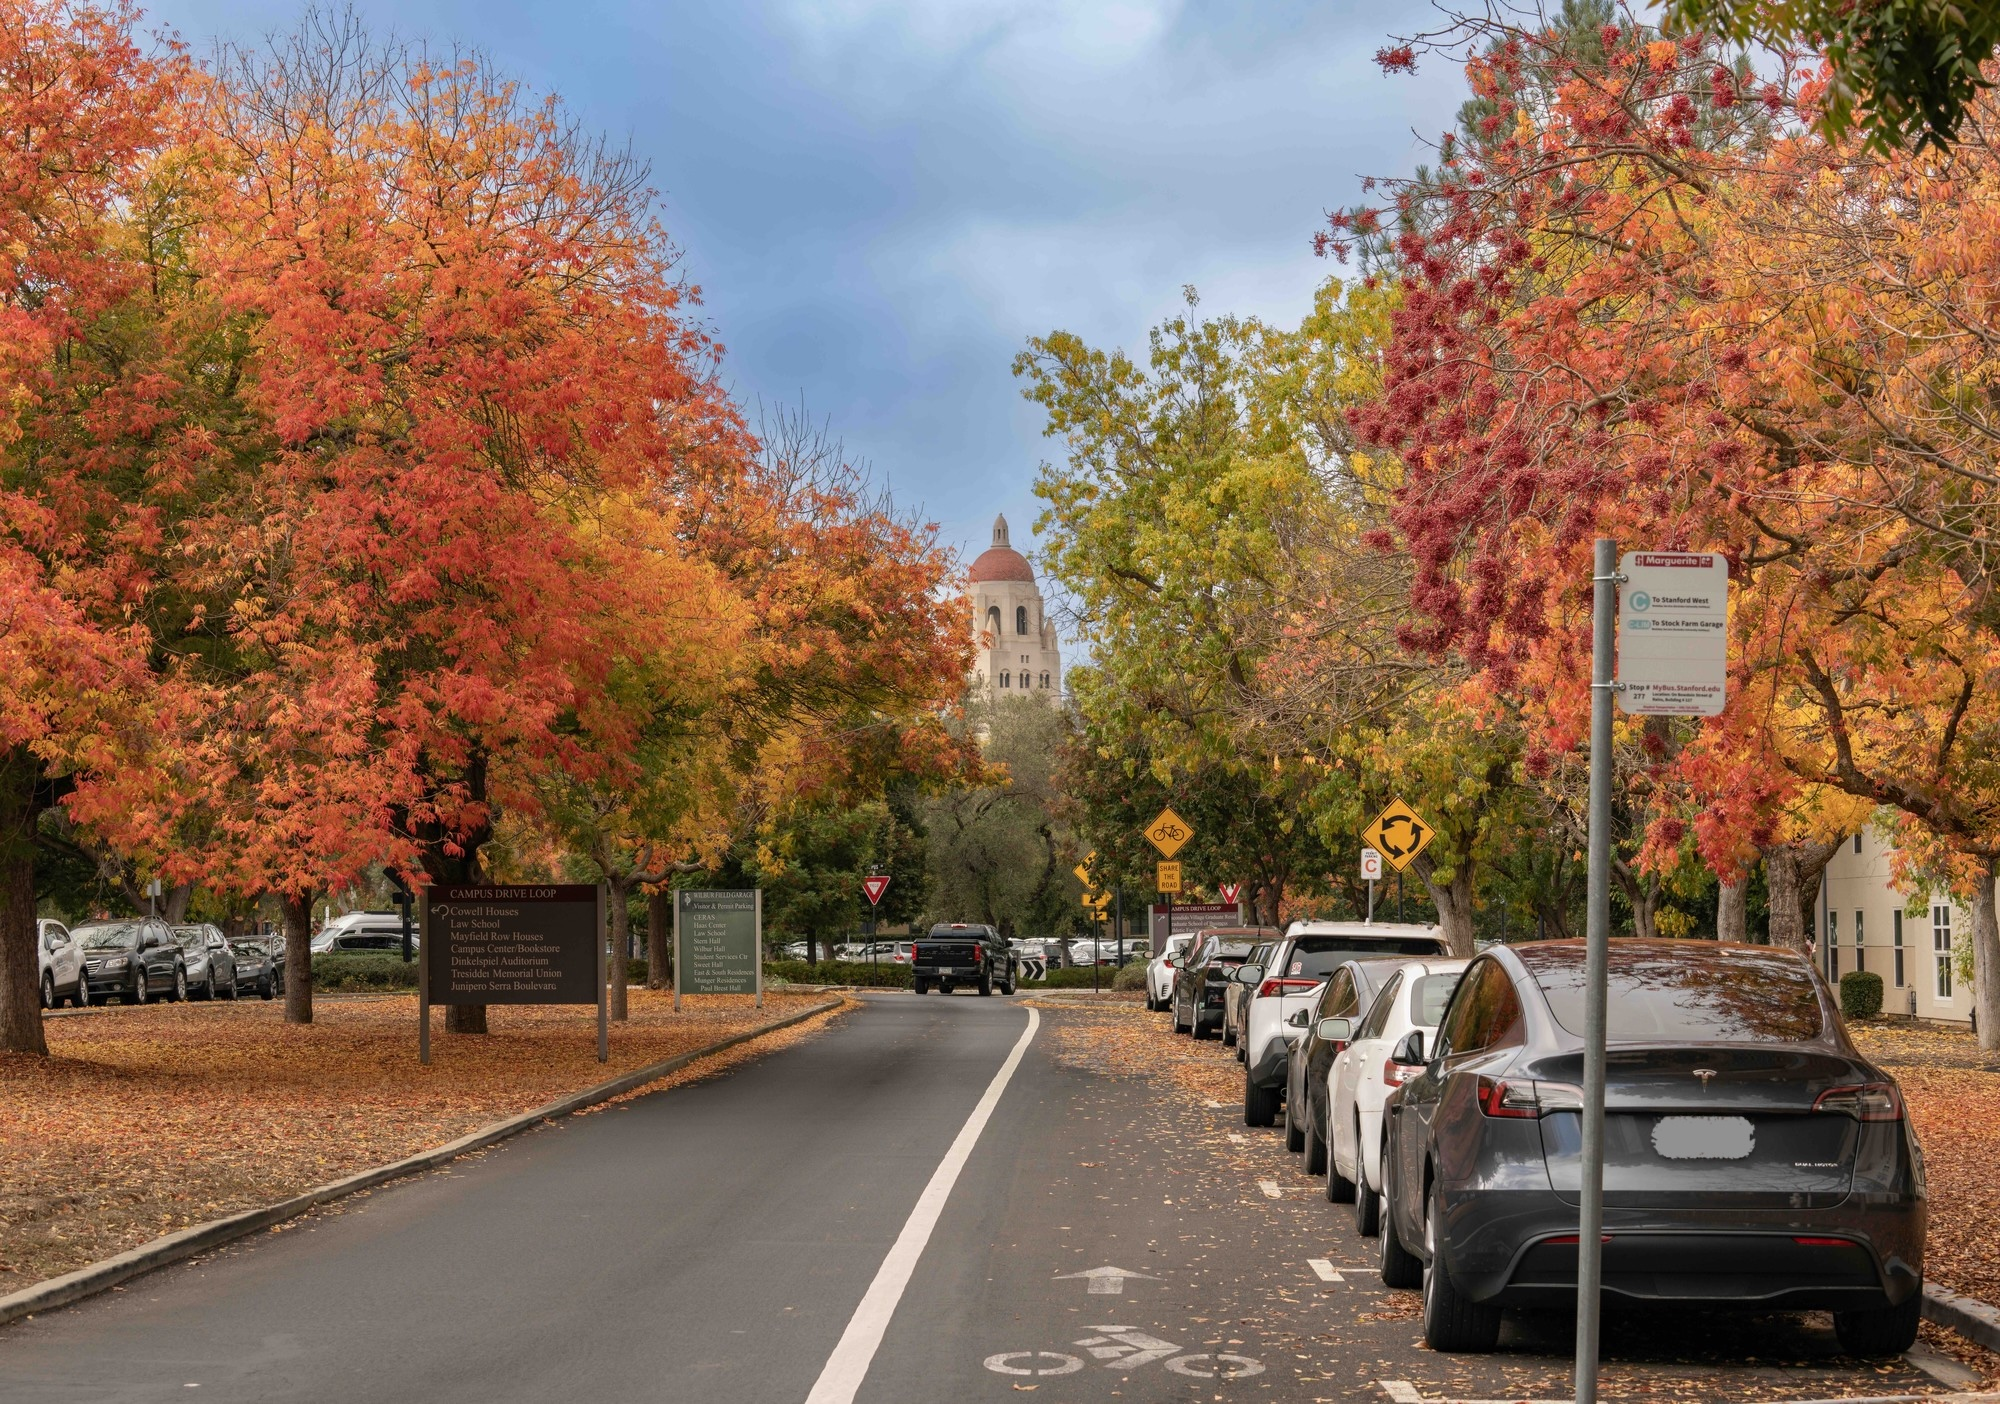

In [11]:
# 5.1 Image understanding with a local image (base64 data URL)
import base64
from pathlib import Path

# Use a sample image included in the repo if available
IMAGE_PATH = Path("DSC03693-Enhanced-SR-small.jpg")
if IMAGE_PATH.exists():
    from IPython.display import Image, display
    display(Image(filename=str(IMAGE_PATH)))

In [12]:
import base64

# Read and base64-encode the image for the Chat Completions API
with IMAGE_PATH.open("rb") as fh:
    image_data = base64.standard_b64encode(fh.read()).decode("utf-8")

# Determine media type from extension
suffix = IMAGE_PATH.suffix.lower()
media_type = "image/png" if suffix == ".png" else "image/jpeg"

In [13]:
# The image data is a base64 encoded string of the image.
print(f"{len(image_data)} characters")
print(image_data[:100])

2031928 characters
/9j/4Q/+RXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMA


# Attach the image to the user message as a multimodal input with type "image_url"

In [14]:
vision_resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Describe what's in this image in a few sentences.",
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:{media_type};base64,{image_data}",
                    },
                },
            ],
        }
    ],
    temperature=0.2,
)
print(vision_resp.choices[0].message.content)

The image depicts a picturesque scene of a tree-lined road adorned with vibrant autumn foliage, showcasing shades of orange, yellow, and red. On either side of the road, parked cars are visible, and there are signs indicating traffic rules and bike lanes. In the background, a distinctive building with a dome can be seen, partially obscured by the trees, suggesting a campus or institutional setting. The overall atmosphere conveys a serene and colorful autumn day.


## 5. Embeddings: Turning Text Into Vectors

- An embedding is a vector of floats representing text semantics
- Similar texts → similar vectors (small distance / high cosine similarity)
- Use cases: semantic search, clustering/visualization, recommendations, entity resolution

In [15]:
# 5.1 Minimal embedding API call and inspection
import numpy as np

EMBED_MODEL = "text-embedding-3-small"

## Basic Syntax for Creating Embedding for a Single Text
- What does an embedding function do? An embedding function maps a text to a vector of floats (called the embedding vector).

- The embedding vector has the property that similar texts have similar vectors.

- The embedding vector is a dense vector of floats, which can be used for various downstream tasks, e.g., semantic search, clustering/visualization, recommendations, entity resolution.


In [16]:
emb = client.embeddings.create(model=EMBED_MODEL, input="Hello, world!")
print(emb.data[0].embedding)

[-0.019143931567668915, -0.025292053818702698, -0.0017211713129654527, 0.01883450709283352, -0.03382139280438423, -0.019682060927152634, -0.02102738246321678, 0.05160655081272125, -0.03218010067939758, -0.03043118305504322, -0.0021508336067199707, -0.028924422338604927, -0.0024871639907360077, -0.03148053586483002, 0.010291713289916515, 0.01856544241309166, -0.04614454507827759, 0.04140901193022728, 0.00043050304520875216, 0.04116685315966606, 0.053651440888643265, 0.0018481360748410225, 0.004564004950225353, 0.009955382905900478, 0.04781274124979973, 0.002164286794140935, -0.00984775647521019, 0.038422394543886185, 0.0009131372789852321, -0.05209086835384369, 0.051122233271598816, -0.032529886811971664, -0.01408552099019289, -0.012605667114257812, 0.013271600939333439, 0.01856544241309166, 0.0016320437425747514, -0.0008479732787236571, -0.012773832306265831, -0.029677802696824074, -0.004510191734880209, -0.015309764072299004, 0.02566874399781227, 0.009047290310263634, -0.0368349142372

In [17]:
print("Embedding shape:", np.array(emb.data[0].embedding).shape)

Embedding shape: (1536,)


## Batch Embedding for Multiple Texts

In [18]:
texts = [
    # Machine learning concepts
    "machine learning",
    "deep learning",
    "neural network",
    "gradient descent",
    "backpropagation",
    "convolutional neural network",
    "recurrent neural network",
    "transformer architecture",
    # Scientific computing concepts
    "numerical integration",
    "finite element method",
    "linear algebra",
    "differential equations",
    "Monte Carlo simulation",
    "matrix factorization",
    "eigenvalue decomposition",
    "sparse matrix computation",
    # Fruits
    "banana",
    "apple",
    "orange",
    "strawberry",
    "mango",
    "pineapple",
    "watermelon",
    "blueberry",
]

# Batch embedding: pass the entire list of texts in a single API call
# The API handles batching internally and returns embeddings in the same order
emb_response = client.embeddings.create(model=EMBED_MODEL, input=texts)
vectors = [np.array(d.embedding) for d in emb_response.data]

In [19]:
print(f"{len(emb_response.data)} embeddings.")
print(f"Shape of the first embedding: {np.array(emb_response.data[0].embedding).shape}")
print(f"First embedding: {emb_response.data[0].embedding[:10]}...")

24 embeddings.
Shape of the first embedding: (1536,)
First embedding: [-0.012126085348427296, -0.011351445689797401, 0.002754438668489456, -0.047455597668886185, 0.03367893397808075, 0.004483969882130623, 0.004346918314695358, 0.03286854177713394, -0.019079962745308876, 0.022833984345197678]...


## Compute Similarity between Embeddings

We quantify how semantically close two texts are using cosine similarity. Given two embedding vectors x and y:

- Normalize:

$$\hat{x} = \frac{x}{\|x\|}, \quad \hat{y} = \frac{y}{\|y\|}$$

- Cosine similarity:

$$\mathrm{sim}(x,y) = \hat{x} \cdot \hat{y} \in [-1,1]$$

Interpretation:
- Values near 1 → very similar meaning; near 0 → unrelated; negative → opposed (rare with most text embeddings).
- If we pre-normalize all vectors, cosine similarity equals the dot product, which is fast to compute in bulk.

In code below we:
- Compute a pairwise similarity matrix across the list `texts`
- Use it for quick inspection, clustering, and visualization


In [20]:
# A small cosine similarity helper
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    a_norm = a / np.linalg.norm(a)
    b_norm = b / np.linalg.norm(b)
    return float(a_norm @ b_norm)

# If real vectors exist, show a quick similarity example
vector1 = np.array(client.embeddings.create(model=EMBED_MODEL, input="machine learning").data[0].embedding)
vector2 = np.array(client.embeddings.create(model=EMBED_MODEL, input="deep learning").data[0].embedding)

sim = cosine_similarity(vector1, vector2)
print("cosine(machine learning, deep learning) ≈", round(sim, 3))

# cosine similarity to self is always 1
sim = cosine_similarity(vector1, vector1)
print("cosine(machine learning, machine learning) ≈", round(sim, 3))

cosine(machine learning, deep learning) ≈ 0.655
cosine(machine learning, machine learning) ≈ 1.0


## Clustermap (Heatmap) of the Similarity Matrix

A clustermap displays the pairwise cosine similarities as colors, often reordering rows/columns via hierarchical clustering to place similar items together.

What to look for:
- Diagonal is 1.0 (each item is identical to itself).
- Symmetric matrix (sim(i,j) = sim(j,i)).
- Blocks of warm colors (high similarity) indicate coherent groups (e.g., all ML terms vs all fruits).
- Cooler colors off-diagonal indicate dissimilar cross-group pairs.

This is a quick way to sanity-check whether embeddings capture expected groupings.

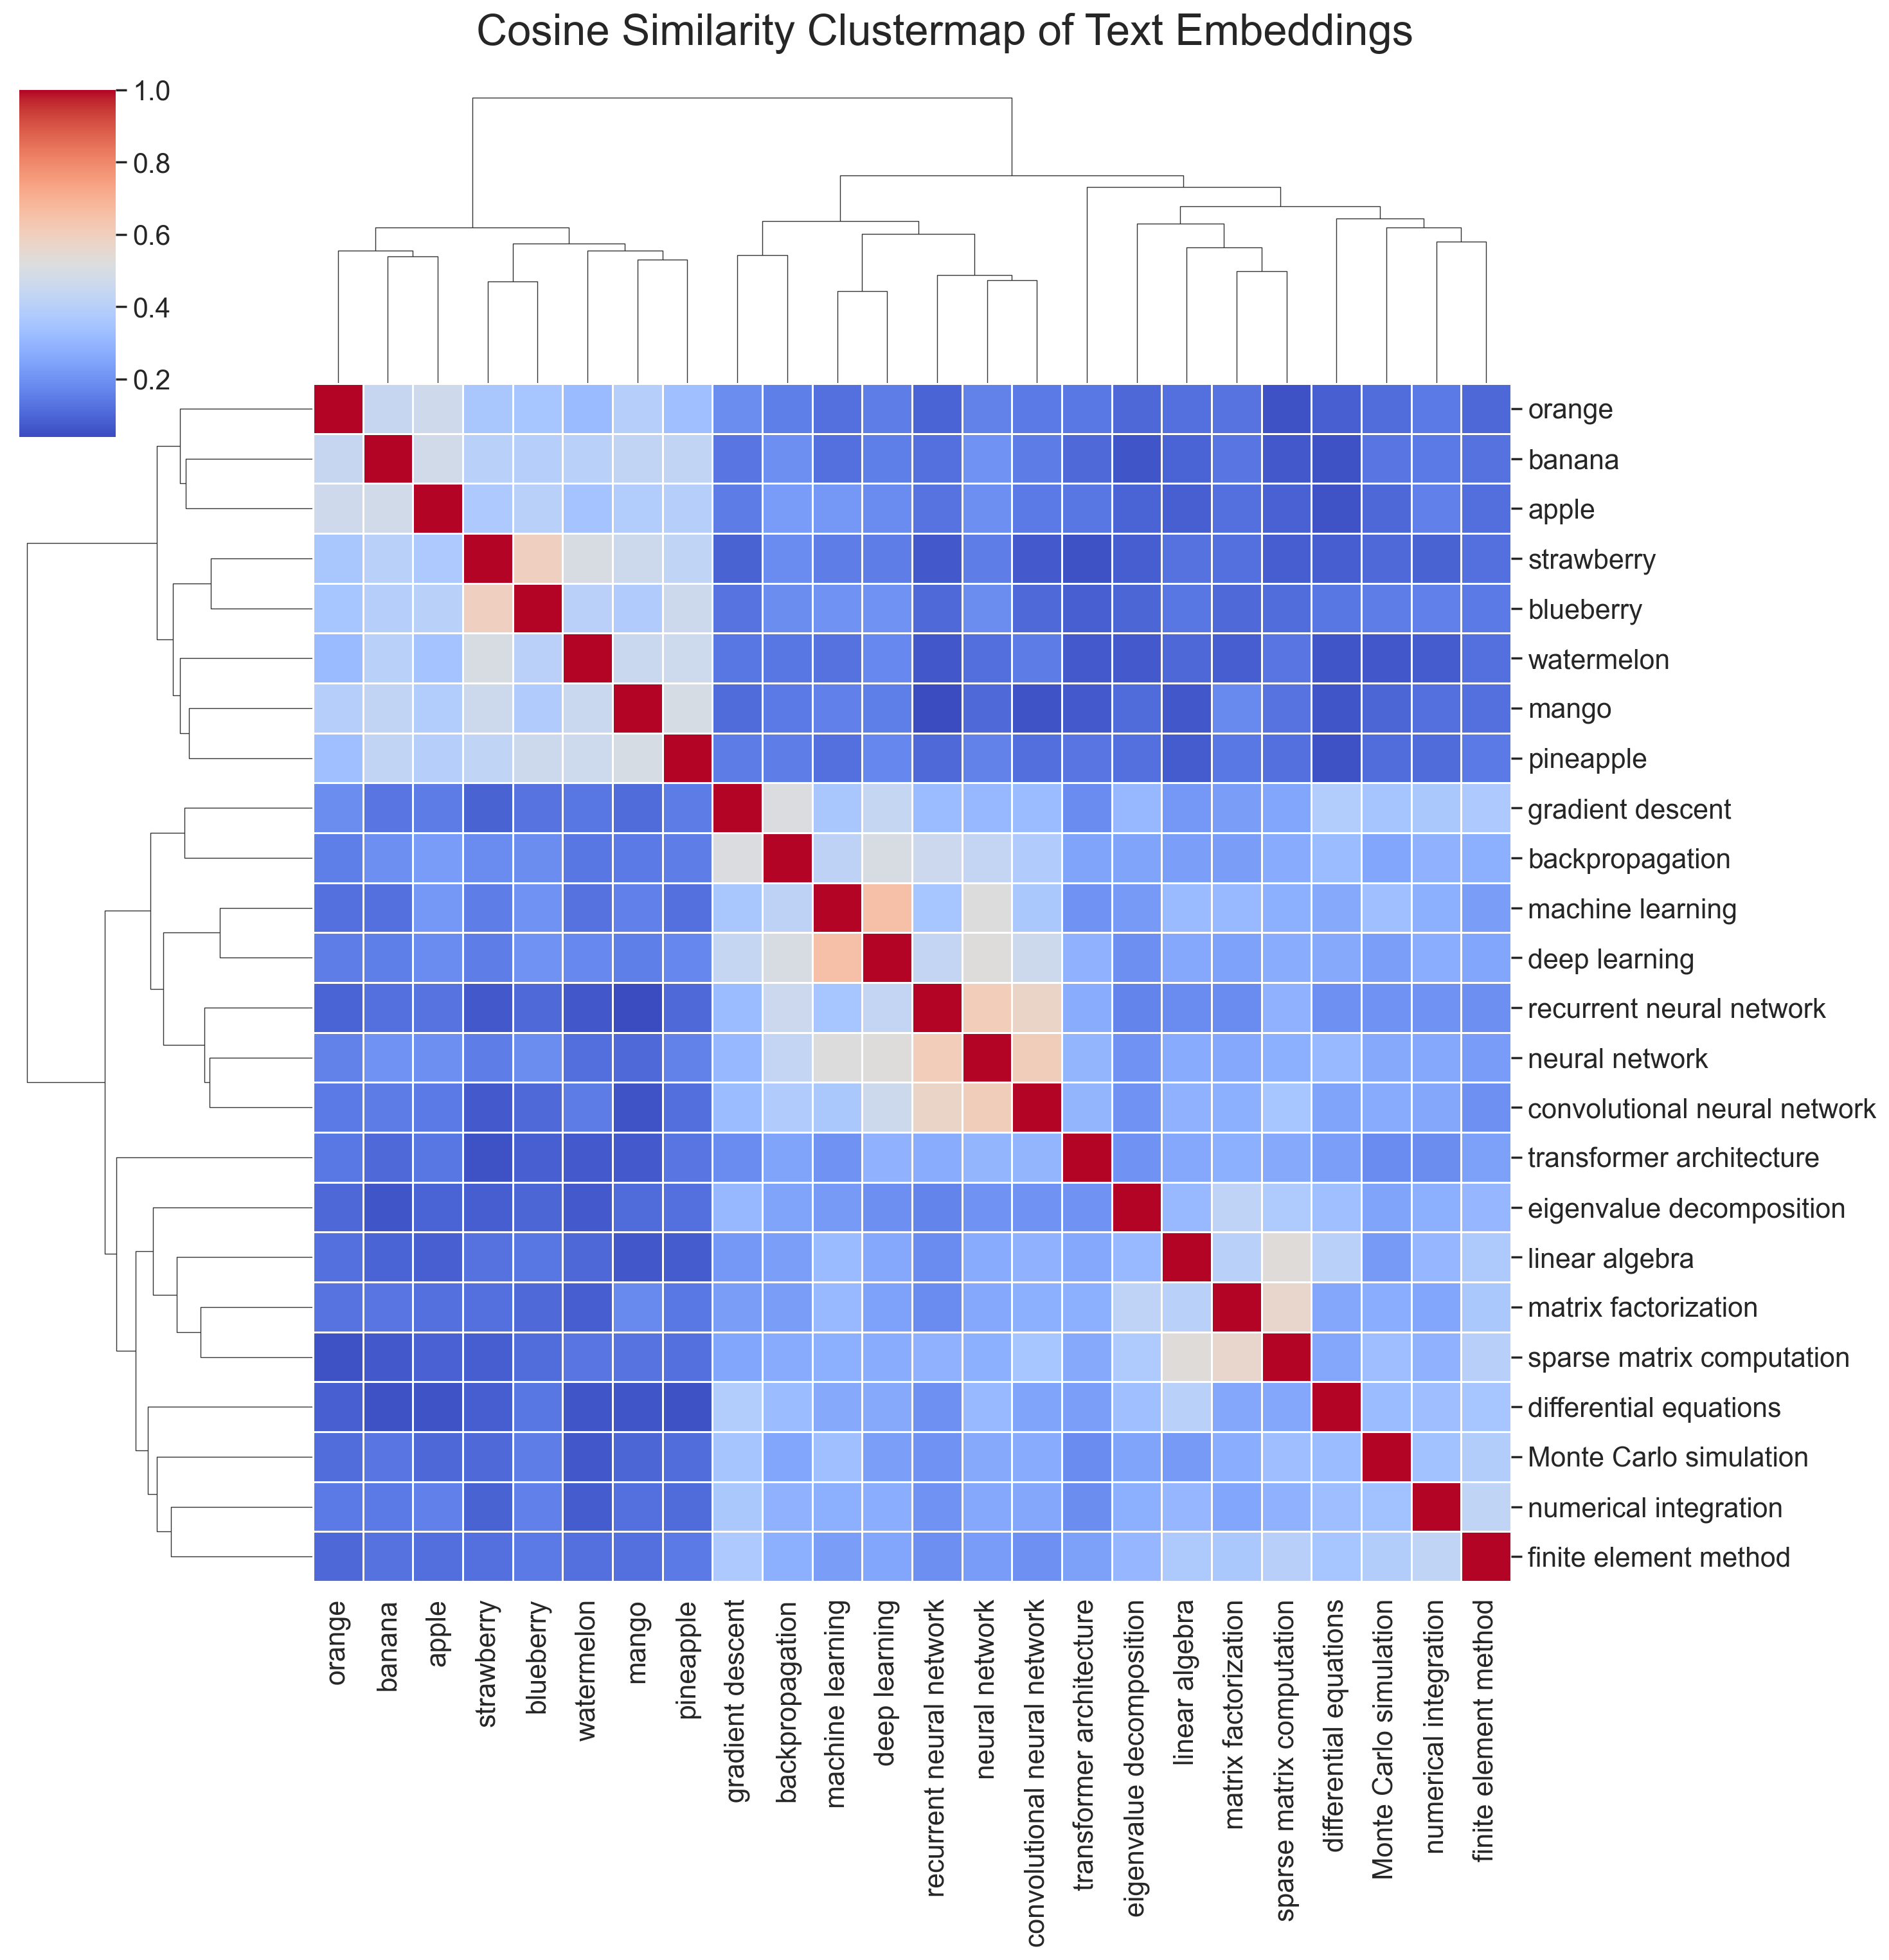

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the full similarity matrix
sim_matrix = np.zeros((len(texts), len(texts)))
for i in range(len(texts)):
    for j in range(len(texts)):
        sim_matrix[i, j] = cosine_similarity(vectors[i], vectors[j])

# Increase font size for classroom presentation
plt.rcParams.update({'font.size': 16})
sns.set(font_scale=1.4)

# Draw clustermap using seaborn with increased DPI and figure size
g = sns.clustermap(
    sim_matrix,
    xticklabels=texts,
    yticklabels=texts,
    cmap="coolwarm",
    figsize=(15, 15),
    annot=False,
    linewidths=0.5,
)
g.fig.set_dpi(200)
g.fig.suptitle("Cosine Similarity Clustermap of Text Embeddings", y=1.02, fontsize=24)
plt.show()


## UMAP Plot for Visualizing Embeddings

UMAP projects high‑dimensional vectors into 2D while attempting to preserve local neighborhoods. It is great for seeing clusters but global distances are approximate.

Notes for use/interpretation:
- `n_neighbors` balances local vs. global structure; `min_dist` controls cluster tightness.
- The projection is stochastic; set a random seed for stable classroom runs.
- Axes have no intrinsic meaning; focus on clusters and local neighborhoods.

Reference: [UMAP documentation](https://umap-learn.readthedocs.io/)


/Users/tianyudu/miniforge3/envs/cme193-autumn-2025/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


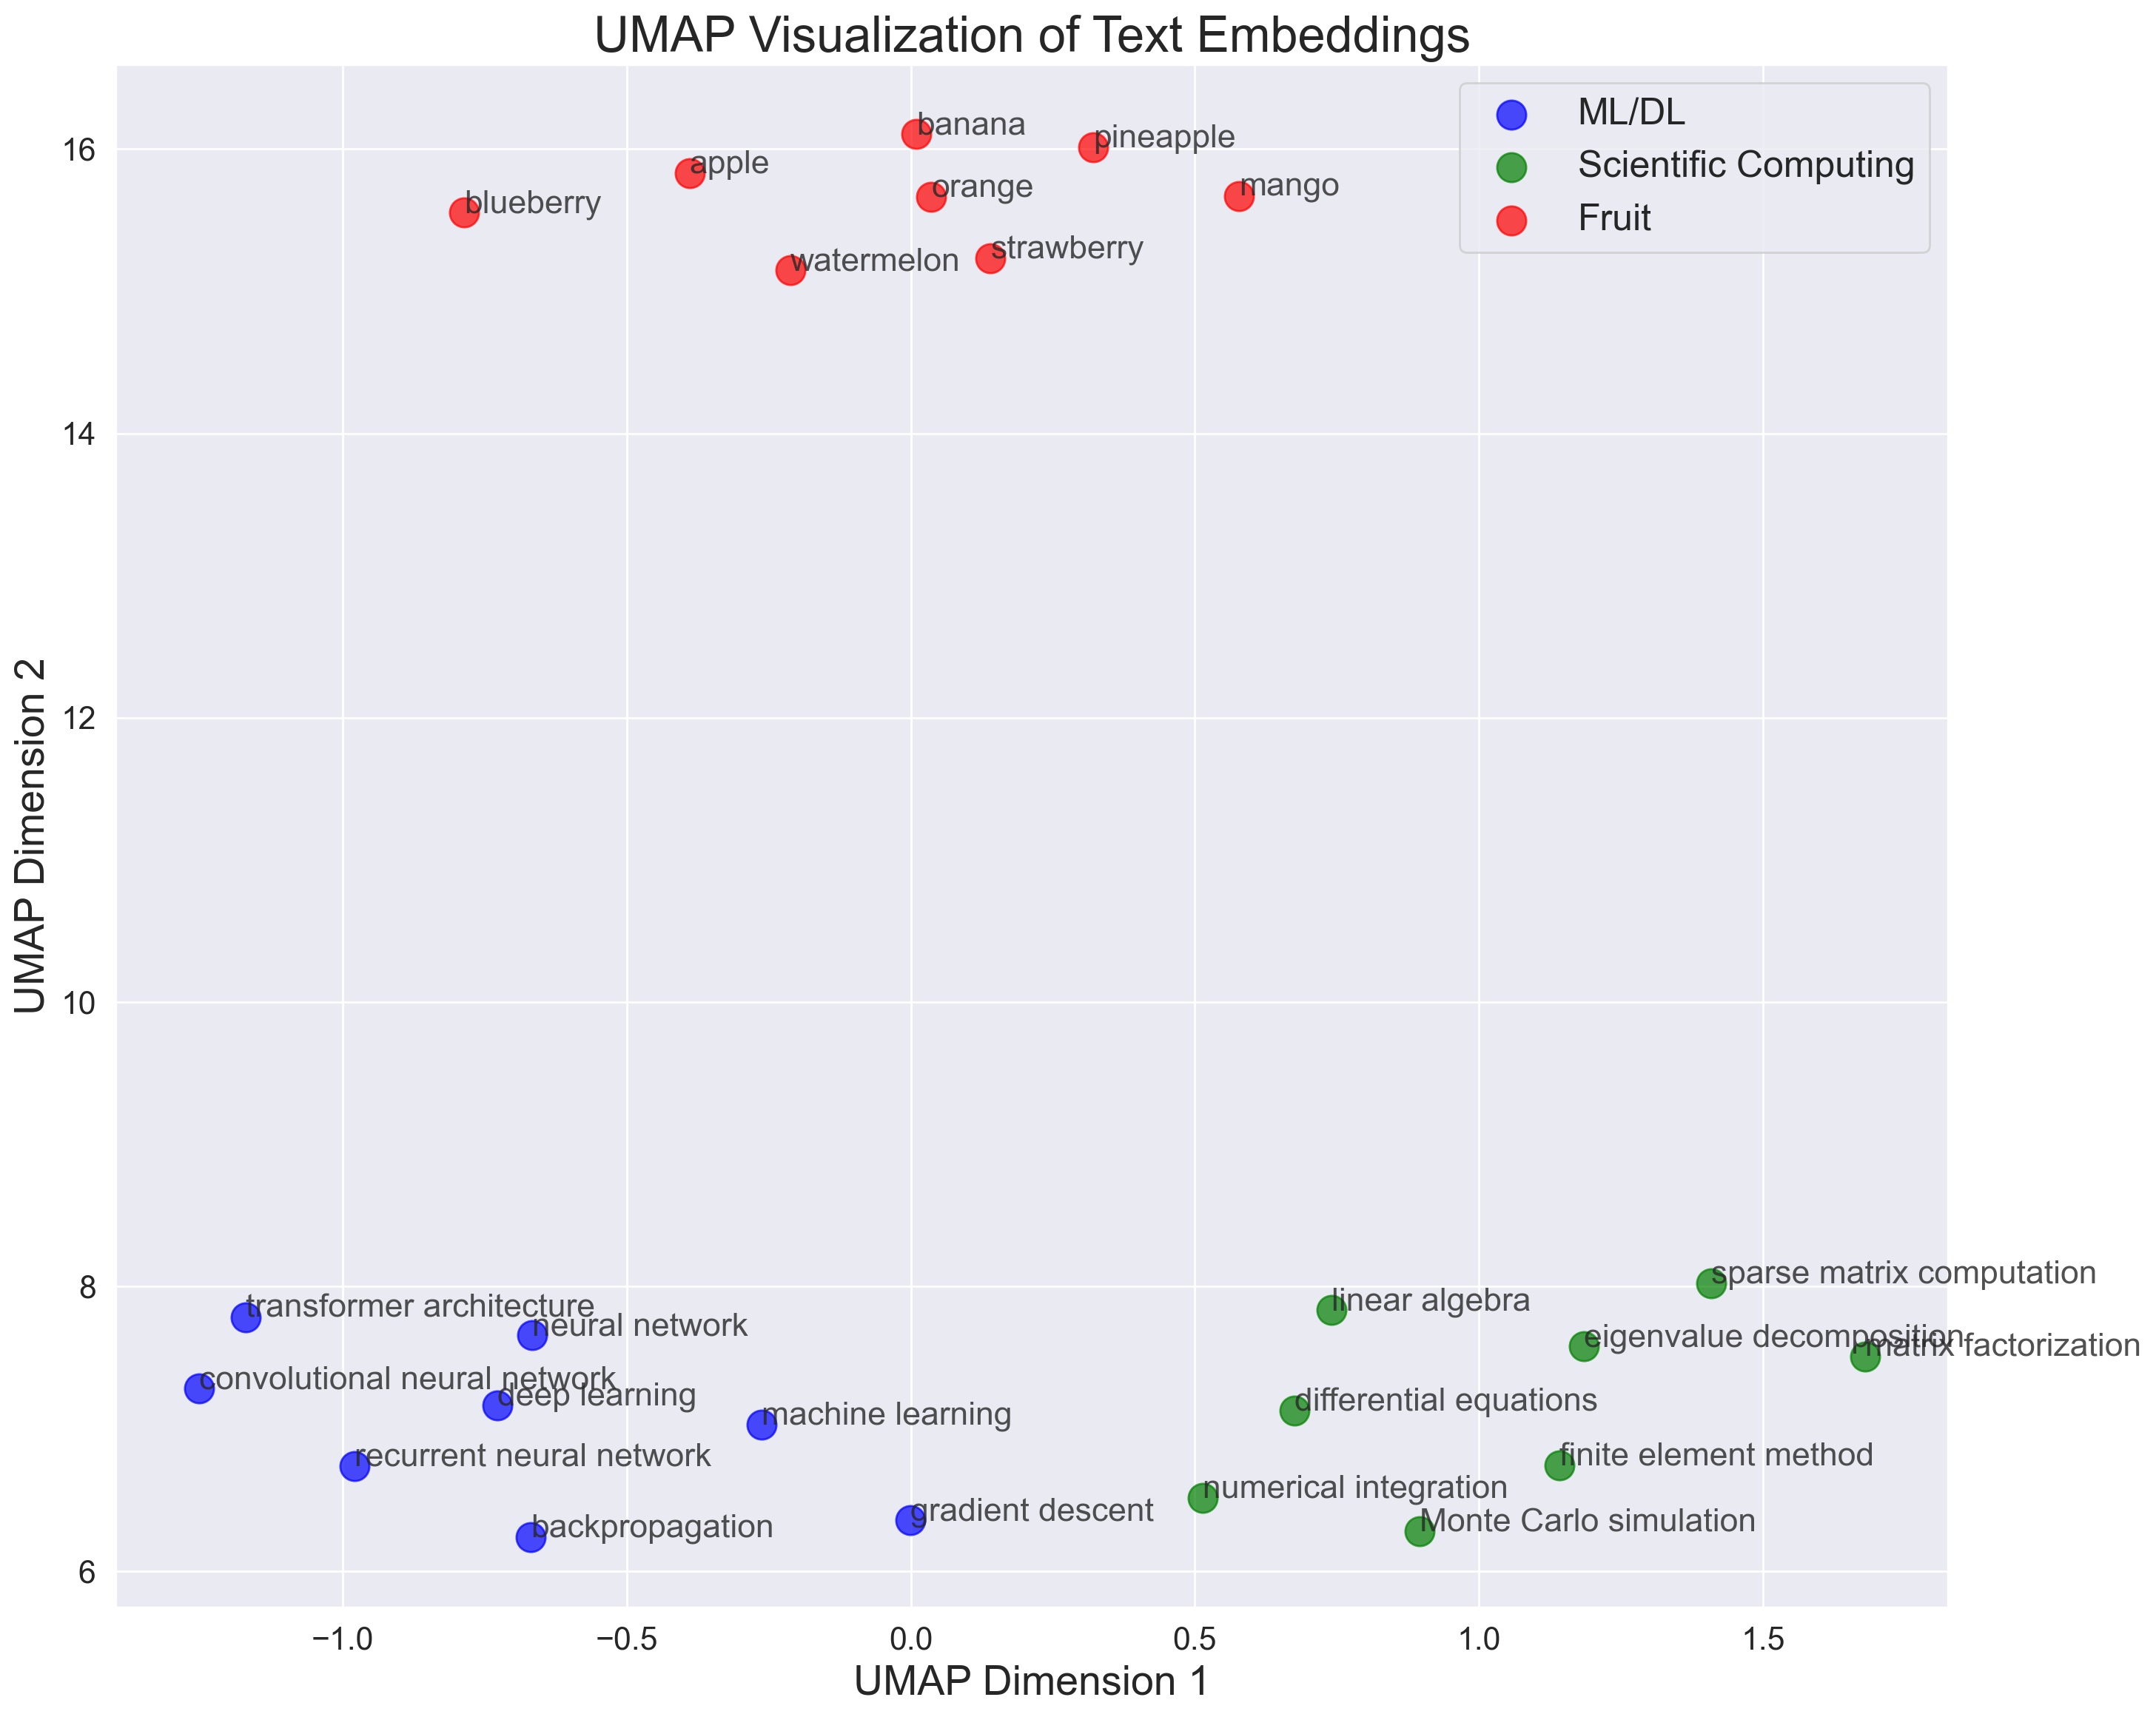

In [22]:
# Visualize embeddings with UMAP

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, min_dist=0.1)
vectors_2d = umap_model.fit_transform(vectors)

# Create labels for coloring by category
categories = (
    ["ML/DL"] * 8 +      # machine learning concepts
    ["Scientific Computing"] * 8 +  # scientific computing concepts
    ["Fruit"] * 8         # fruits
)

# Plot with increased DPI and font size for classroom presentation
plt.figure(figsize=(15, 12), dpi=200)
plt.rcParams.update({'font.size': 20})
colors = {"ML/DL": "blue", "Scientific Computing": "green", "Fruit": "red"}

for cat in colors:
    mask = [c == cat for c in categories]
    pts = vectors_2d[mask]
    plt.scatter(pts[:, 0], pts[:, 1], c=colors[cat], label=cat, s=200, alpha=0.7)

# Annotate points with text labels
for i, txt in enumerate(texts):
    plt.annotate(txt, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=16, alpha=0.8)

plt.title("UMAP Visualization of Text Embeddings", fontsize=24)
plt.xlabel("UMAP Dimension 1", fontsize=20)
plt.ylabel("UMAP Dimension 2", fontsize=20)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()


Goal: Map messy, self‑reported affiliations (typos/abbreviations) to a canonical list of university names.

Approach:
1) Compute embeddings for canonical names (batch)
2) For each reported affiliation, embed and compute cosine similarity to all canonical vectors

Motivating example:
- A recruiter ingests thousands of resumes with self‑reported affiliations like "MIT", "Stanford Univ.", or misspellings like "Princton".
- The HR system stores a canonical list (e.g., "Massachusetts Institute of Technology", "Stanford University", "Princeton University").
- We use embeddings to map each noisy input string to its most similar canonical entry automatically, and flag low‑confidence cases for manual review.

Mathematical description:
- Let $$c_i$$ be the canonical names and $$e_i = \mathrm{normalize}(\mathrm{embed}(c_i))$$ their unit embeddings
- For a reported string q, compute $$v = \mathrm{normalize}(\mathrm{embed}(q))$$
- Score by cosine similarity $$s_i = e_i\cdot v$$. Choose the best match $$i^* = \arg\max_i s_i$$
- If $$s_{i^*} < \tau$$ (threshold), mark as "uncertain" for human review. This balances automation with quality control.


## 6. Fuzzy Matching University Names with Embeddings

Goal: Map messy, self‑reported affiliations (typos/abbreviations) to a canonical list of university names.

Approach:
1) Compute embeddings for canonical names (batch)
2) For each reported affiliation, embed and compute cosine similarity to all canonical vectors

Motivating example:
- A recruiter ingests thousands of resumes with self‑reported affiliations like "MIT", "Stanford Univ.", or misspellings like "Princton".
- The HR system stores a canonical list (e.g., "Massachusetts Institute of Technology", "Stanford University", "Princeton University").
- We use embeddings to map each noisy input string to its most similar canonical entry automatically, and flag low‑confidence cases for manual review.

Mathematical description:
- Let $$c_i$$ be the canonical names and $$e_i = \mathrm{normalize}(\mathrm{embed}(c_i))$$ their unit embeddings
- For a reported string q, compute $$v = \mathrm{normalize}(\mathrm{embed}(q))$$
- Score by cosine similarity $$s_i = e_i\cdot v$$. Choose the best match $$i^* = \arg\max_i s_i$$
- If $$s_{i^*} < \tau$$ (threshold), mark as "uncertain" for human review. This balances automation with quality control

In [23]:
# 6.1 Canonical list of university names
school_names_in_system = [
    "Massachusetts Institute of Technology",
    "Stanford University",
    "Harvard University",
    "California Institute of Technology",
    "Princeton University",
    "Yale University",
    "University of Chicago",
    "Columbia University",
    "University of Pennsylvania",
    "Duke University",
    "Northwestern University",
    "Johns Hopkins University",
    "Cornell University",
    "University of California, Berkeley",
    "University of California, Los Angeles",
    "University of Michigan",
    "Carnegie Mellon University",
    "New York University",
    "Brown University",
    "University of Southern California",
    "University of Virginia",
    "Georgetown University",
    "University of North Carolina at Chapel Hill",
    "University of Florida",
    "University of Texas at Austin",
    "Boston University",
    "University of Wisconsin-Madison",
    "University of Illinois Urbana-Champaign",
    "Georgia Institute of Technology",
    "Rice University",
]

print(f"Using canonical list with {len(school_names_in_system)} university names.")

Using canonical list with 30 university names.


In [24]:
import pandas as pd
reported_affiliations = [
    "MIT",
    "Stanford Univ.",
    "Harvard U",
    "Cal Tech",
    "Princton",
    "Yale Univeristy",
    "U Chicago",
    "Columbia Uni.",
    "UPenn",
    "Duke Univ, Durham",
]

pd.DataFrame({"reported_affiliation": reported_affiliations})

,reported_affiliation
0,MIT
1,Stanford Univ.
2,Harvard U
3,Cal Tech
4,Princton
5,Yale Univeristy
6,U Chicago
7,Columbia Uni.
8,UPenn
9,"Duke Univ, Durham"


In [25]:
# 6.2 Batch-embed canonical names, then match reported affiliations
from typing import List, Tuple

can_emb_resp = client.embeddings.create(
    model=EMBED_MODEL,
    input=school_names_in_system,
)
canonical_vectors = np.array([item.embedding for item in can_emb_resp.data])
canonical_vectors_norm = canonical_vectors / np.linalg.norm(
    canonical_vectors, axis=1, keepdims=True
)
print("Canonical embeddings shape:", canonical_vectors.shape)


def embed_text(text: str) -> np.ndarray:
    resp = client.embeddings.create(model=EMBED_MODEL, input=[text])
    return np.array(resp.data[0].embedding)


def find_top_matches(query: str, top_k: int = 3) -> List[Tuple[str, float]]:
    """Return list of (canonical_name, similarity_score) for top_k matches."""
    q_vec = embed_text(query)
    q_vec = q_vec / np.linalg.norm(q_vec)
    sims = canonical_vectors_norm @ q_vec  # cosine similarities
    top_indices = np.argsort(sims)[::-1][:top_k]
    return [(school_names_in_system[i], float(sims[i])) for i in top_indices]


results = []
for aff in reported_affiliations:
    top_matches = find_top_matches(aff, top_k=3)
    for rank, (name, score) in enumerate(top_matches, start=1):
        results.append({
            "reported_affiliation": aff,
            "rank": rank,
            "matched_canonical_name": name,
            "similarity": score,
        })

matches_df = pd.DataFrame(results)
matches_df

Canonical embeddings shape: (30, 1536)


,reported_affiliation,rank,matched_canonical_name,similarity
0,MIT,1,Massachusetts Institute of Technology,0.623797
1,MIT,2,California Institute of Technology,0.463304
2,MIT,3,Georgia Institute of Technology,0.432200
3,Stanford Univ.,1,Stanford University,0.896482
4,Stanford Univ.,2,"University of California, Berkeley",0.578103
5,Stanford Univ.,3,Harvard University,0.490667
6,Harvard U,1,Harvard University,0.891775
7,Harvard U,2,Yale University,0.623902
8,Harvard U,3,Princeton University,0.607857
9,Cal Tech,1,California Institute of Technology,0.707773


## Observations

- Abbreviations resolve correctly: "MIT" → "Massachusetts Institute of Technology", "Stanford Univ." → "Stanford University", "U Chicago" → "University of Chicago".
- Typos are handled: "Princton" → "Princeton University"; "Yale Univeristy" → "Yale University".
- Location noise is tolerated: "Duke Univ, Durham" → "Duke University".
- Similarity scores near 1.0 indicate strong matches; use a threshold (e.g., 0.90) to flag uncertain cases for human review.
- If multiple canonicals score similarly, consider showing the top‑k to a human, or augment the query with extra context (city, department) before matching.

# Thank you all for your participation this quarter!
# Attendance Form
![Attendance Form](images/CME193_Lecture_10_Attendance_Form.png)
